# Proyecto Final Integrador
## Equipo 4

## Predicción de riesgo de default en microcréditos, con datos de Lending Club (2007-2015) 
Predicting Microloan default risk with Lending Club data (2007-2015)

## Introduction

Estamos interesados en usar modelos predictivos para evaluar riesgo en microcréditos, como los otorgados por la fintech local Afluenta.
Encontramos un dataset de Lending Club en Kaggle, con features muy similares, y 2.2 millones de observaciones. 



Pueden ver más información sobre Afluenta en  www.afluenta.com 
y el dataset de Lending Club en: https://www.kaggle.com/wendykan/lending-club-loan-data



### Contenido:

00 - Data Load <br>
01 - Exploratory Data Analysis <br>
02 - Data Cleaning and Transformation <br>
03 - Benchmark - KNN <br>
04 - Random Forest <br>
05 - XGBoost <br>
06 - Feature Engineering <br>
07 - GridSearch <br>
08 - Pipeline and final model <br>
09 - Results <br>
10 - Sources and credits <br>

## Paso 0: Data load

In [1]:
# Importamos las librerías
import pandas as pd
import numpy as np


# Opcionesd de configuración para poder visualizar el dataset
pd.options.display.max_columns = None
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', 200)

In [2]:
# Full version para modelo final
# df = pd.read_csv('loan.csv',parse_dates=['issue_d'])


# Muestreo para Exploratory Data Analysis y testeo de modelos
df_ = pd.read_csv('../loan.csv',parse_dates=['issue_d'])

C:\Users\Usuario\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df = pd.DataFrame(df_).sample (80000)
df_completo = pd.DataFrame (df_)

Podemos ver los features que tenemos disponibles. Vamos a analizar los siguientes features: <br>
- loan_amnt
- int_rate
- installment
- grade
- subgrade 
- term
- emp_lenght
- annual_income
- delinq_2yrs
- dti
- open_acc

- emp_title
- home_ownership
- verification_status
- purpose
- application_type

## Paso 2: Data Cleaning y Transformaciones

Hasta acá tenemos identificados los features que queremos usar. Vamos a eliminar las columnas innecesarias, y adoptar estrategias para gestionar los features categóricos.

#### Preparación del Target
Vamos a quedarnos solamente con los créditos terminados, ya sea pagados (1) o irrecuperables (0)

In [4]:
# Tomamos el Target y nos quedamos solamente con los créditos terminados
df = df[(df.loan_status == 'Fully Paid') | (df.loan_status == 'Charged Off')]  

In [5]:
df['Fully Paid'] = pd.get_dummies(df.loan_status, drop_first = True)

In [6]:
df['Fully Paid'].value_counts()

1    36535
0     9294
Name: Fully Paid, dtype: int64

Tenemos un desbalance de 80/20 hacia el 1 del target

#### 2.1 Transformaciones de features categóricos
Tomamos los siguientes features: <br>
- emp_title
- home_ownership
- verification_status
- purpose
- application_type

In [7]:
# Lista de Variables categoricas
cat = ['application_type', 'purpose', 'verification_status', 'home_ownership']

In [8]:
# Dummies
df_dummies = pd.get_dummies(df[cat])
df_dummies.head()

,application_type_Individual,application_type_Joint App,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
1739868,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
497329,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
82521,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1152514,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1901719,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


##### Tratamiento de emp_title
Este feature tiene alta cardinalidad: Una serie de valores con muchas apariciones, y una long-tail de observaciones menos comunes

#### 2.2 Transformaciones de features numéricos

In [9]:
#df['emp_length'] = df.emp_length.str.extract('(\d+)').astype(float)

In [10]:
df['emp_length'].value_counts()

10+ years    14854
2 years       4169
3 years       3796
< 1 year      3622
1 year        3017
5 years       2960
4 years       2727
6 years       2099
8 years       2075
7 years       2054
9 years       1731
Name: emp_length, dtype: int64

In [11]:
# Term
df.term.value_counts()

 36 months    34632
 60 months    11197
Name: term, dtype: int64

In [12]:
terms = {" 60 months" :60, " 36 months" :36}
df['term'] = df['term'].map(terms)

In [13]:
df.term

1739868    60
497329     36
82521      60
1152514    36
1901719    36
1313443    36
1327414    36
1999992    36
674605     36
612787     36
471821     36
734163     36
2056754    60
684403     36
1311367    36
1994585    36
1976408    36
1645348    36
1054600    60
1539376    36
1860841    36
1185006    36
724660     36
411553     36
646836     36
2084639    60
1112081    36
1719193    36
550467     36
1540290    60
1963969    60
1919606    60
1044690    36
564362     36
702992     60
1322524    36
1417298    36
680948     36
1263697    36
1204090    36
1014664    60
1838970    36
1180172    36
2063605    36
1288845    60
1010067    36
1802260    36
1454034    36
1855463    36
813408     36
536260     36
1439155    36
1416183    36
1891123    60
734402     36
208852     60
1777533    60
910304     36
1783117    36
1597959    60
708777     36
2063853    36
1710782    36
765557     36
537631     36
2131986    36
1590120    36
565234     60
1010007    36
1483213    36
507863     36
942129

In [14]:
# Grade
df.grade.value_counts()

B    13368
C    13014
A     7839
D     6824
E     3327
F     1136
G      321
Name: grade, dtype: int64

In [15]:
di = {"A":1, "B":2, "C":3, "D":4, "E":5,"F":6, "G":7}
df['grade'] = df['grade'].map(di)

In [16]:
df.grade.value_counts()

2    13368
3    13014
1     7839
4     6824
5     3327
6     1136
7      321
Name: grade, dtype: int64

#### 2.3 Creación del dataset final

In [17]:
#df = df[['loan_amnt', 'int_rate', 'annual_inc', 'delinq_2yrs', 'dti', 'grade', 'term', 'installment', 'open_acc' ]].join(df_dummies)

In [18]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,Fully Paid
1739868,NaN,NaN,35000,35000,34975.0,60,25.80,1043.78,7,G1,Airgas,10+ years,MORTGAGE,170000.0,Verified,2013-08-01,Fully Paid,n,NaN,NaN,home_improvement,Home Improvement,064xx,CT,8.47,0.0,Jun-1984,5.0,34.0,NaN,11.0,0.0,2682,12.4,48.0,w,0.0,0.0,40796.508183,40767.37,35000.0,5796.51,0.0,0.0,0.0,Jun-2014,15449.45,NaN,May-2018,0.0,34.0,1,Individual,NaN,NaN,NaN,0.0,0.0,43241.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21700.0,NaN,NaN,NaN,6.0,6177.0,9371.0,10.8,0.0,0.0,126.0,355.0,1.0,1.0,1.0,23.0,NaN,1.0,35.0,5.0,1.0,3.0,5.0,11.0,11.0,9.0,36.0,3.0,11.0,0.0,0.0,0.0,3.0,89.0,0.0,0.0,0.0,71681.0,43241.0,10500.0,49981.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1
497329,NaN,NaN,2825,2825,2825.0,36,24.99,112.31,5,E4,Police,10+ years,MORTGAGE,60000.0,Source Verified,2016-09-01,Charged Off,n,NaN,NaN,debt_consolidation,Debt consolidation,186xx,PA,33.70,0.0,Aug-2000,1.0,40.0,NaN,9.0,0.0,12717,55.3,26.0,f,0.0,0.0,1119.180000,1119.18,587.8,531.38,0.0,0.0,0.0,Aug-2017,112.31,NaN,Feb-2019,0.0,40.0,1,Individual,NaN,NaN,NaN,0.0,0.0,271767.0,0.0,3.0,1.0,2.0,10.0,53250.0,77.0,0.0,1.0,9557.0,68.0,23000.0,1.0,0.0,2.0,4.0,30196.0,3443.0,73.5,0.0,0.0,106.0,193.0,16.0,10.0,1.0,43.0,NaN,2.0,40.0,1.0,1.0,3.0,2.0,8.0,7.0,5.0,17.0,3.0,9.0,0.0,0.0,0.0,1.0,96.2,50.0,0.0,0.0,305918.0,65967.0,13000.0,71813.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
82521,NaN,NaN,15000,15000,15000.0,60,25.34,443.27,5,E3,NaN,NaN,MORTGAGE,37000.0,Source Verified,2018-11-01,Fully Paid,n,NaN,NaN,major_purchase,Major purchase,333xx,

#### 2.4 Separación de sets de entrenamiento y test

In [19]:
# Creo y
y = df['Fully Paid']

In [20]:
df = df[['loan_amnt', 'int_rate', 'annual_inc', 'delinq_2yrs', 'dti']].join(df_dummies)
df.head()

,loan_amnt,int_rate,annual_inc,delinq_2yrs,dti,application_type_Individual,application_type_Joint App,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
1739868,35000,25.80,170000.0,0.0,8.47,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
497329,2825,24.99,60000.0,0.0,33.70,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
82521,15000,25.34,37000.0,0.0,3.02,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1152514,8400,8.18,73000.0,0.0,12.56,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1901719,2000,8.39,120000.0,1.0,16.28,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [21]:
# Creo X
X = df

In [22]:
# Checkeo nulos
X.isna().sum()

loan_amnt                               0
int_rate                                0
annual_inc                              0
delinq_2yrs                             0
dti                                    11
application_type_Individual             0
application_type_Joint App              0
purpose_car                             0
purpose_credit_card                     0
purpose_debt_consolidation              0
purpose_educational                     0
purpose_home_improvement                0
purpose_house                           0
purpose_major_purchase                  0
purpose_medical                         0
purpose_moving                          0
purpose_other                           0
purpose_renewable_energy                0
purpose_small_business                  0
purpose_vacation                        0
purpose_wedding                         0
verification_status_Not Verified        0
verification_status_Source Verified     0
verification_status_Verified      

In [23]:
y.isna().sum()

0

In [24]:
X = X.fillna(0)
X.isna().sum()

loan_amnt                              0
int_rate                               0
annual_inc                             0
delinq_2yrs                            0
dti                                    0
application_type_Individual            0
application_type_Joint App             0
purpose_car                            0
purpose_credit_card                    0
purpose_debt_consolidation             0
purpose_educational                    0
purpose_home_improvement               0
purpose_house                          0
purpose_major_purchase                 0
purpose_medical                        0
purpose_moving                         0
purpose_other                          0
purpose_renewable_energy               0
purpose_small_business                 0
purpose_vacation                       0
purpose_wedding                        0
verification_status_Not Verified       0
verification_status_Source Verified    0
verification_status_Verified           0
home_ownership_A

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)



## Paso 3: Benchmark

#### K-Nearest Neighbours

In [26]:
import time
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

In [27]:
model_knn = KNeighborsClassifier(n_jobs=-1)

In [28]:
params = {"n_neighbors":list(range(3,8))}

In [29]:
knn = GridSearchCV(model_knn, params, verbose= True)

Imputamos los NA con 0

In [30]:
X_train_na = X_train.fillna(0)
X_test_na = X_test.fillna(0)

In [31]:
stds = StandardScaler()

In [32]:
X_train_knn = stds.fit_transform(X_train_na)

In [33]:
X_test_knn = stds.transform(X_test_na)

In [34]:
start = time.time()
knn.fit(X_train_knn, y_train)
end = time.time()
print(f"La búsqueda con knn llevó: {end - start:.2f} segundos")

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.9min finished


La búsqueda con knn llevó: 116.41 segundos


In [35]:
knn.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=7, p=2,
                     weights='uniform')

#### Corro con todo el dataset

In [36]:
model_knn_total = KNeighborsClassifier(leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=7, p=2,
                     weights='uniform')

In [37]:
{}

{}

In [38]:
y_predicted_knn = knn.predict_proba(X_test_knn)
knn_auc = roc_auc_score(y_test, y_predicted_knn[:,1])
print("El valor del AUC es: ", knn_auc)

El valor del AUC es:  0.6189741275234306


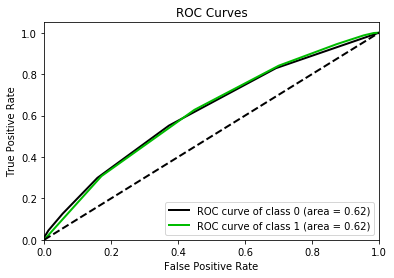

In [39]:
plot_roc(y_test, y_predicted_knn, plot_micro=False, plot_macro=False);

#### Random Forest


In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
model_rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)

In [42]:
import scipy.stats as st

A RandomizedSearchCV los hiperparámetros se los podemos pasar como una lista o también como una distribución de scipy.

In [43]:
params = {  
    "n_estimators": st.randint(20,40), # Number of boosted trees to fit.
    "max_depth": st.randint(3, 12)     # Maximum tree depth for base learners.
}

In [44]:
rf = RandomizedSearchCV(model_rf, params, n_iter=25, verbose= True, scoring = 'recall')

In [45]:
start = time.time()
rf.fit(X_train_na,y_train)
end = time.time()
print("La búsqueda con Random Forest llevó: ", end - start, " segundos")

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   26.2s finished


La búsqueda con Random Forest llevó:  26.828391790390015  segundos


In [46]:
rf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=11, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=26, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

#### Uso el dataset completo

In [48]:
model_rf_total = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=11, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=24, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [49]:
y_predicted_rf = rf.predict_proba(X_test_na)

In [50]:
rf_auc = roc_auc_score(y_test,y_predicted_rf[:,1])
print("El valor del AUC es: ", rf_auc)

El valor del AUC es:  0.6867503597872263


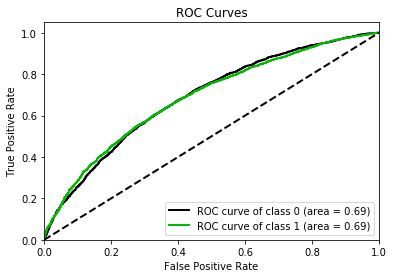

In [51]:
plot_roc(y_test, y_predicted_rf, plot_micro=False, plot_macro=False);

#### XGBoost

Vamos a importar el clasificador XGBoost del módulo xgboost.sklearn que nos provee clases y métodos aceptados por la API de sklearn. La clase que contiene este clasificador se llama XGBClassifier

In [52]:
import xgboost as xgb
model_xgb = xgb.XGBClassifier(class_weight='balanced', n_jobs=-1)

Podemos partir del siguiente conjunto de hiperparámetros, que serán empleados también luego.

In [53]:
one_to_left = st.beta(10, 1) # Esta distribución nos dará valores entre 0 y 1 mayormente cercanos a 1

params = {  
    "n_estimators": st.randint(20,40), # Number of boosted trees to fit.
    "max_depth": st.randint(3, 12),     # Maximum tree depth for base learners.
    "learning_rate": st.uniform(0.05, 0.4), #     Boosting learning rate (xgb’s “eta”)
    "colsample_bytree": one_to_left, #     Subsample ratio of columns when constructing each tree.
    "subsample": one_to_left,     # Subsample ratio of the training instance.
    "gamma": st.uniform(0, 10), #     Minimum loss reduction required to make a further partition on a leaf node of the tree.
    'reg_alpha': st.uniform(0.05,10),   # L1 regularization term on weights
    "min_child_weight": st.uniform(1,20), #    Minimum sum of instance weight(hessian) needed in a child.
}

Se puede consultar los parámetros <a href="http://xgboost.readthedocs.io/en/latest/python/python_api.html"> aquí </a>

Realizamos la búsqueda de hiperparámetrosRandomiezSearchCV con 25 iteraciones

In [54]:
xgb_cv = RandomizedSearchCV(model_xgb, params, n_iter=25, verbose=True)

Busco el mejor set de hiperparámetros y calculamos el tiempo

¿Es necesario normalizar los features antes de aplicar XGBoost?

In [55]:
start = time.time()
xgb_cv.fit(X_train,y_train)
end = time.time()
print("La búsqueda con XGBoost llevó: ", end - start, " segundos")

C:\Users\Usuario\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   56.3s finished


La búsqueda con XGBoost llevó:  57.44843935966492  segundos


In [56]:
y_predicted_xgb = xgb_cv.predict_proba(X_test)

In [57]:
y_predicted_xgb[:,0].shape

(11458,)

In [58]:
xgb_auc = roc_auc_score(y_test, y_predicted_xgb[:,1])
print("El valor del AUC es: ", xgb_auc)

El valor del AUC es:  0.6968379515469838


In [59]:
xgb_cv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.8718724670905895, gamma=8.887741613547536,
              learning_rate=0.13332611092227337, max_delta_step=0, max_depth=4,
              min_child_weight=8.4714489063014, missing=None, n_estimators=31,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=5.504462290309696, reg_lambda=1,
              scale_pos_weight=1, seed=None, silent=None,
              subsample=0.9784897782747283, verbosity=1)

In [60]:
xgb_total = xgb.XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9758277174554955, gamma=9.82135040062063,
              learning_rate=0.29517828947447816, max_delta_step=0, max_depth=4,
              min_child_weight=1.2913805786569723, missing=None,
              n_estimators=27, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=0,
              reg_alpha=7.587896803286751, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.9299965909673373,
              verbosity=1)

Graficamos la curva ROC por clase

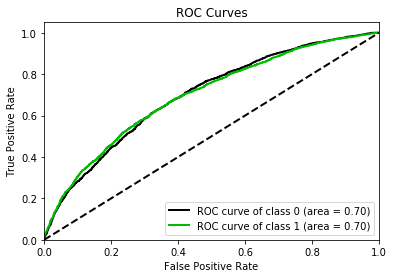

In [61]:
plot_roc(y_test, y_predicted_xgb, plot_micro=False, plot_macro=False);

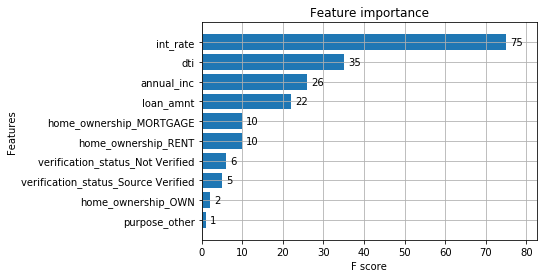

In [62]:
xgb.plot_importance(xgb_cv.best_estimator_, height=0.8, max_num_features=10);

Entonces, los principales atributos son:
- profit on operating activities / financial expenses
- (current assets - inventory) / short-term liabilities
- sales (n) / sales (n-1)
- operating expenses / total liabilities
- logarithm of total assets

También se pueden acceder los valores directamente con el atributo `feature_importances_`

In [63]:
print(xgb_cv.best_estimator_.feature_importances_)

[0.06521416 0.40394008 0.05036743 0.         0.07174072 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.04219647 0.
 0.         0.         0.         0.12241069 0.03994953 0.03093383
 0.         0.05842367 0.         0.         0.03218794 0.08263546]


#### Reentrenamos los modelos con el dataset completo y los parámetros encontrados con el sample

In [65]:
df = df_completo
df = df[(df.loan_status == 'Fully Paid') | (df.loan_status == 'Charged Off')] 
df['Fully Paid'] = pd.get_dummies(df.loan_status, drop_first = True)
cat = ['application_type', 'purpose', 'verification_status', 'home_ownership']
df_dummies = pd.get_dummies(df[cat])
terms = {" 60 months" :60, " 36 months" :36}
df['term'] = df['term'].map(terms)
di = {"A":1, "B":2, "C":3, "D":4, "E":5,"F":6, "G":7}
df['grade'] = df['grade'].map(di)


y = df['Fully Paid']
df = df[['loan_amnt', 'int_rate', 'annual_inc', 'delinq_2yrs', 'dti']].join(df_dummies)

X = df
X = X.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X,y)



C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [81]:
X_train.shape

(977705, 30)

In [66]:
model_rf_total = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=11, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=24, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [67]:
model_rf_total.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=11, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=24, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [68]:
y_predicted_rf = model_rf_total.predict_proba(X_test)

In [69]:
rf_auc = roc_auc_score(y_test,y_predicted_rf[:,1])

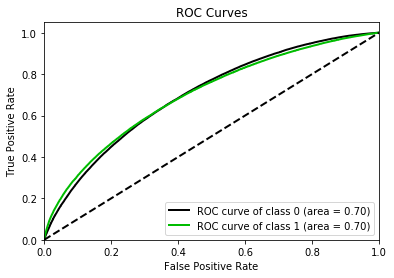

In [70]:
plot_roc(y_test, y_predicted_rf, plot_micro=False, plot_macro=False);

In [71]:
rf_auc

0.6983457029555821

In [72]:
xgb_total = xgb.XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9758277174554955, gamma=9.82135040062063,
              learning_rate=0.29517828947447816, max_delta_step=0, max_depth=4,
              min_child_weight=1.2913805786569723, missing=None,
              n_estimators=27, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=0,
              reg_alpha=7.587896803286751, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.9299965909673373,
              verbosity=1)

In [73]:
xgb_total.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9758277174554955, gamma=9.82135040062063,
              learning_rate=0.29517828947447816, max_delta_step=0, max_depth=4,
              min_child_weight=1.2913805786569723, missing=None,
              n_estimators=27, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=0,
              reg_alpha=7.587896803286751, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.9299965909673373,
              verbosity=1)

In [74]:
y_predicted_xgb_total = xgb_cv.predict_proba(X_test)

In [75]:
xgb_auc = roc_auc_score(y_test, y_predicted_xgb_total[:,1])

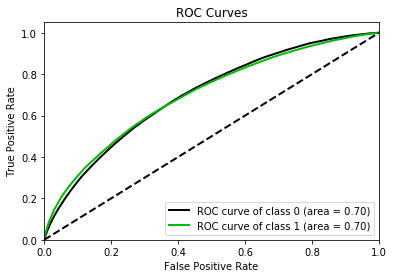

In [76]:
plot_roc(y_test, y_predicted_xgb_total, plot_micro=False, plot_macro=False);

In [77]:
roc_auc_score(y_test, y_predicted_xgb_total[:,1])

0.6982150701692461

El score final es 0.6998